# Time Series Forecasting with XGBoost
Advanced Demand Forecasting with Recursive and Ensemble Methods

In [300]:
!pip install skforecast

In [50]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
from skforecast.recursive._forecaster_recursive import ForecasterRecursive
from sklearn.base import clone

## Data Loading
### Load and Clean the Dataset

In [29]:
# Load the historical demand dataset
df = pd.read_csv(r"historic_demand_2009_2024.csv", index_col=0)

# Print basic information about the loaded dataset
print("Original dataset shape:", df.shape)
print("Column names:", df.columns.tolist())

# Remove columns with null values
# Note: These columns contain values that started appearing after a specific year
# and might be useful in future analyses
df.drop(columns=["nsl_flow", "eleclink_flow", "scottish_transfer", "viking_flow", "greenlink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48 (data quality issue)
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

# Select only the columns we need for this analysis
df = df[['settlement_date', 'settlement_period', 'tsd', 'is_holiday']]

# Remove days with zero demand (likely data quality issues)
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()
null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Display the cleaned dataset
print("\nCleaned dataset shape:", df.shape)
print("First 5 rows of cleaned data:")
print(df.head())
print("\nData summary statistics:")
print(df.describe())

Original dataset shape: (279264, 23)
Column names: ['settlement_date', 'settlement_period', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday']

Cleaned dataset shape: (278512, 4)
First 5 rows of cleaned data:
  settlement_date  settlement_period    tsd  is_holiday
0      2009-01-01                  1  38704           1
1      2009-01-01                  2  38964           1
2      2009-01-01                  3  38651           1
3      2009-01-01                  4  37775           1
4      2009-01-01                  5  37298           1

Data summary statistics:
       settlement_period            tsd     is_holiday
count      278512.000000  278512.000000  278512.000000
m

## Feature Engineering
### Create Date-Time Features

In [30]:
def add_datepart(df):
    """
    Create comprehensive datetime features from the settlement date and period.

    Args:
        df (DataFrame): DataFrame containing settlement_date and settlement_period columns

    Returns:
        DataFrame: DataFrame with added datetime features
    """
    # Convert 'settlement_date' to datetime (ensure it's in the correct format)
    df["settlement_date"] = pd.to_datetime(df["settlement_date"])

    # Ensure that 'settlement_period' is an integer and calculate the period offset in minutes
    df["period_offset"] = pd.to_timedelta((df["settlement_period"] - 1) * 30, unit="m")

    # Add the period offset (Timedelta) to the settlement_date (Datetime) to get the timestamp
    df["timestamp"] = df["settlement_date"] + df["period_offset"]

    # Ensure 'timestamp' is in datetime format (in case it's not already)
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Create time-related features from timestamp
    df["day_of_week"] = df["timestamp"].dt.dayofweek  # Monday=0, Sunday=6
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["month"] = df["timestamp"].dt.month
    df["quarter"] = df["timestamp"].dt.quarter
    df["is_month_end"] = df["timestamp"].dt.is_month_end.astype(int)
    df["is_month_start"] = df["timestamp"].dt.is_month_start.astype(int)
    df["is_quarter_end"] = df["timestamp"].dt.is_quarter_end.astype(int)
    df["is_quarter_start"] = df["timestamp"].dt.is_quarter_start.astype(int)
    df["is_year_end"] = df["timestamp"].dt.is_year_end.astype(int)
    df["is_year_start"] = df["timestamp"].dt.is_year_start.astype(int)
    df["day_of_year"] = df["timestamp"].dt.dayofyear
    df["week_of_year"] = df["timestamp"].dt.isocalendar().week.astype(int)
    df["hour"] = df["timestamp"].dt.hour
    df["minute"] = df["timestamp"].dt.minute
    return df


In [31]:

# Apply the datetime feature engineering function
print("Adding datetime features...")
df = add_datepart(df)

# Clean up and set the timestamp as index
df.drop(columns=["period_offset", "settlement_date"], inplace=True)
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)

# Show the dataframe with new features
print("\nDataset with datetime features:")
print(df.head())
print(f"Number of features: {df.shape[1]}")

Adding datetime features...

Dataset with datetime features:
                     settlement_period    tsd  is_holiday  day_of_week  \
timestamp                                                                
2009-01-01 00:00:00                  1  38704           1            3   
2009-01-01 00:30:00                  2  38964           1            3   
2009-01-01 01:00:00                  3  38651           1            3   
2009-01-01 01:30:00                  4  37775           1            3   
2009-01-01 02:00:00                  5  37298           1            3   

                     is_weekend  month  quarter  is_month_end  is_month_start  \
timestamp                                                                       
2009-01-01 00:00:00           0      1        1             0               1   
2009-01-01 00:30:00           0      1        1             0               1   
2009-01-01 01:00:00           0      1        1             0               1   
2009-01-01 01:3


## Data Exploration and Visualization
Examine Dataset Correlations and Patterns

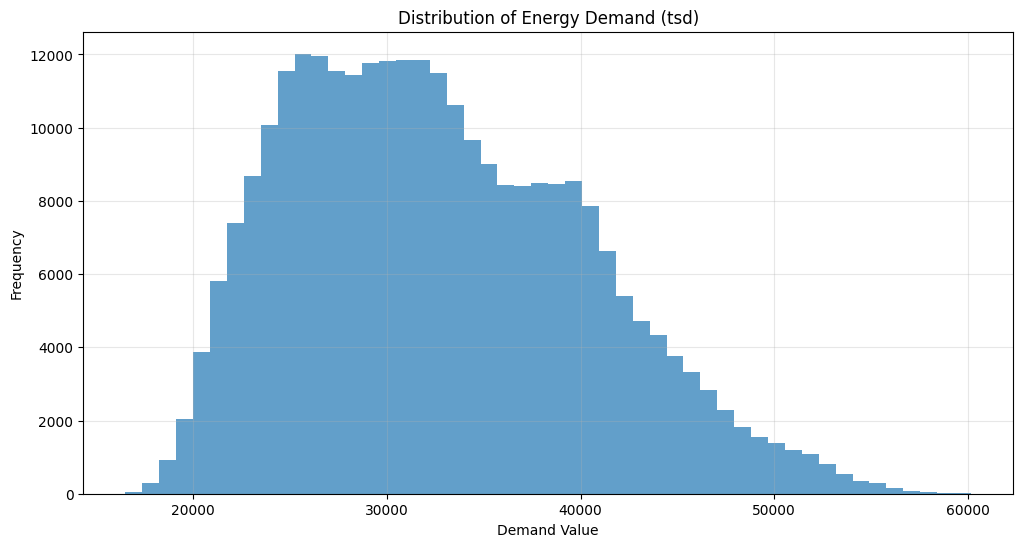

Generating correlation matrix heatmap...


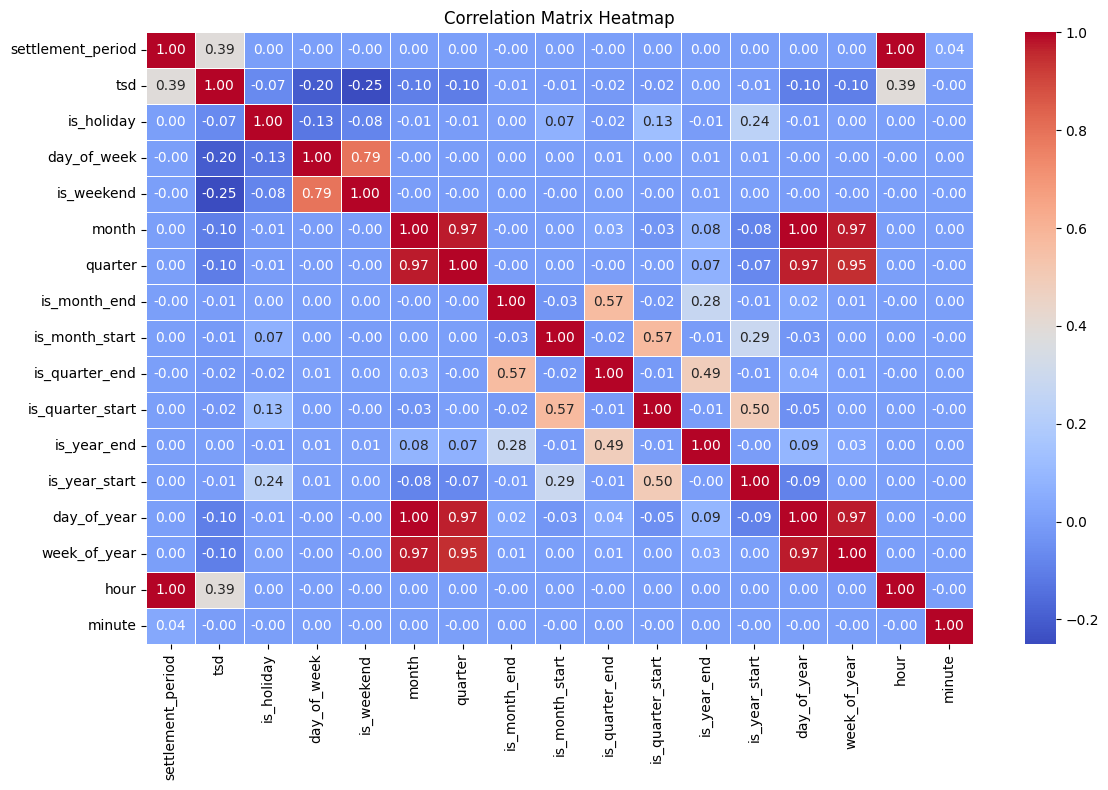

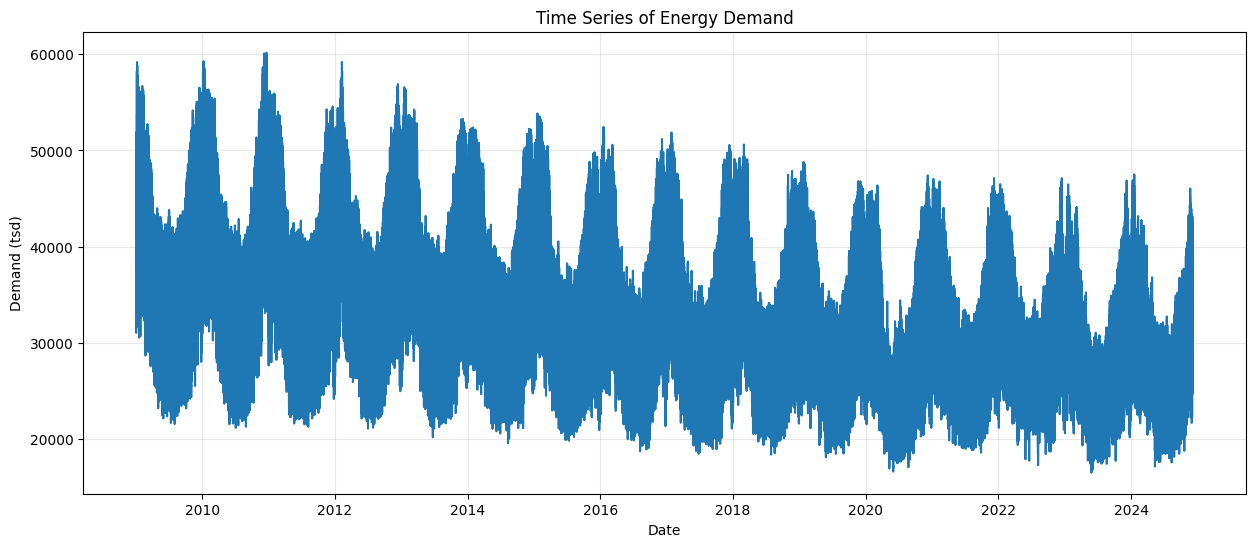

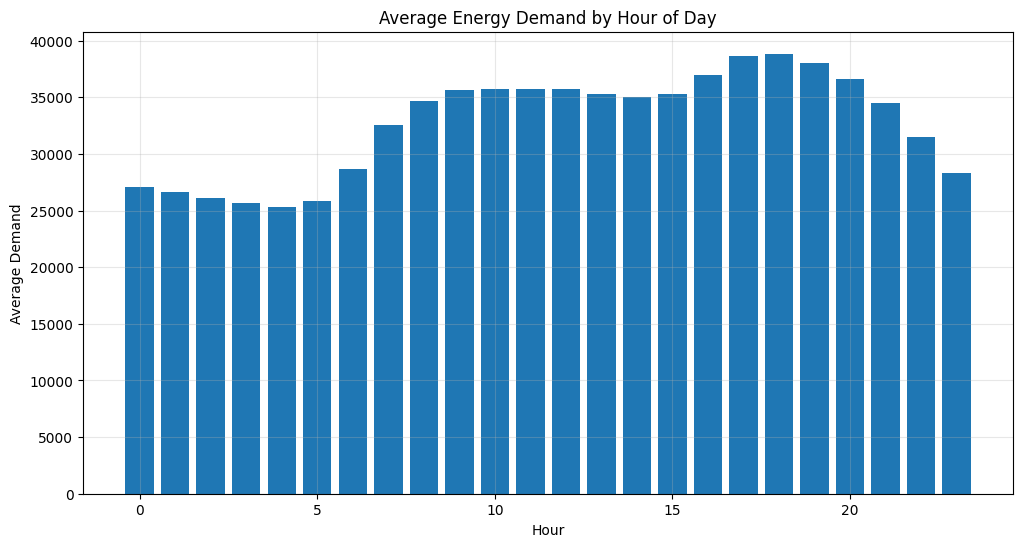

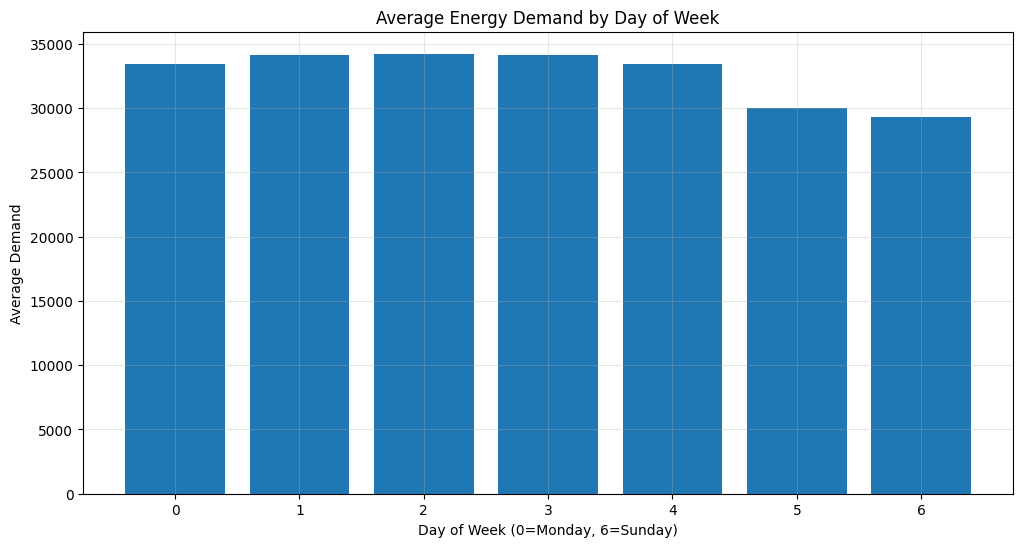

In [32]:

# Plot the distribution of the target variable (tsd)
plt.figure(figsize=(12, 6))
plt.hist(df['tsd'], bins=50, alpha=0.7)
plt.title('Distribution of Energy Demand (tsd)')
plt.xlabel('Demand Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Display correlation matrix heatmap
print("Generating correlation matrix heatmap...")
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Plot time series of the target variable
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['tsd'])
plt.title('Time Series of Energy Demand')
plt.xlabel('Date')
plt.ylabel('Demand (tsd)')
plt.grid(True, alpha=0.3)
plt.show()

# Examine patterns by hour of day
hourly_avg = df.groupby(df.index.hour)['tsd'].mean()
plt.figure(figsize=(12, 6))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average Energy Demand by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Demand')
plt.grid(True, alpha=0.3)
plt.show()

# Examine patterns by day of week
daily_avg = df.groupby('day_of_week')['tsd'].mean()
plt.figure(figsize=(12, 6))
plt.bar(daily_avg.index, daily_avg.values)
plt.title('Average Energy Demand by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Demand')
plt.grid(True, alpha=0.3)
plt.show()


Create Features for Forecasting

In [33]:

def create_features(df, target_col, lag_periods=48, forecast_horizon=48):
    """
    Create lag features for time series forecasting.

    Args:
        df (DataFrame): Dataframe containing time series data
        target_col (str): Target column to create lags for
        lag_periods (int): Number of lag periods to create
        forecast_horizon (int): Number of periods ahead to forecast

    Returns:
        tuple: (X, y) Feature dataframe and target series
    """
    # Create a copy of the dataframe to avoid modifying the original
    data = df.copy()

    # Create lag features
    for lag in range(1, lag_periods + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)

    # Create the target variable (forecast_horizon steps ahead)
    data['target'] = data[target_col].shift(-forecast_horizon)

    # Drop NaN values that result from shifting
    data = data.dropna()

    # Separate features and target
    y = data['target']
    X = data.drop('target', axis=1)

    return X, y

## Prepare Data for Training

In [34]:

def train_test_split_ts(X, y, test_size=0.2):
    """
    Split time series data chronologically into train and test sets.

    Args:
        X (DataFrame): Feature dataframe
        y (Series): Target series
        test_size (float): Fraction of data to use for testing

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    return X_train, X_test, y_train, y_test


In [ ]:
# def walk_forward_validation(X, y, forecast_horizon=48, n_windows=3):
#     """
#     Create multiple train/test splits using walk-forward validation.
    
#     Args:
#         X (DataFrame): Feature dataframe
#         y (Series): Target series
#         forecast_horizon (int): Number of periods to forecast
#         n_windows (int): Number of validation windows
        
#     Returns:
#         list: List of (X_train, X_test, y_train, y_test) tuples
#     """
#     splits = []
#     total_samples = len(X)
    
#     # Reserve at least n_windows * forecast_horizon samples at the end
#     reserved_samples = n_windows * forecast_horizon
#     max_train_idx = total_samples - reserved_samples
    
#     for i in range(n_windows):
#         # Calculate end of training set for this window
#         train_end_idx = max_train_idx + (i * forecast_horizon)
#         # Test set is exactly forecast_horizon samples
#         test_end_idx = train_end_idx + forecast_horizon
        
#         # Create the split
#         X_train, X_test = X.iloc[:train_end_idx], X.iloc[train_end_idx:test_end_idx]
#         y_train, y_test = y.iloc[:train_end_idx], y.iloc[train_end_idx:test_end_idx]
        
#         splits.append((X_train, X_test, y_train, y_test))
    
#     return splits

In [36]:
def walk_forward_validation(X, y, forecast_horizon=48, n_windows=3, random_selection=True, random_seed=42):
    """
    Create multiple train/test splits using walk-forward validation with optional randomization.
    
    Args:
        X (DataFrame): Feature dataframe
        y (Series): Target series
        forecast_horizon (int): Number of periods to forecast
        n_windows (int): Number of validation windows
        random_selection (bool): Whether to randomly select start points for validation windows
        random_seed (int): Random seed for reproducibility
        
    Returns:
        list: List of (X_train, X_test, y_train, y_test) tuples
    """
    splits = []
    total_samples = len(X)
    
    # Ensure we have enough data for n_windows
    if total_samples < (n_windows * forecast_horizon):
        raise ValueError(f"Not enough data for {n_windows} windows of size {forecast_horizon}")
    
    # Calculate the valid range for starting test windows
    min_train_size = forecast_horizon * 2  # Ensure at least 2x forecast_horizon for training
    max_start_idx = total_samples - forecast_horizon
    
    if random_selection:
        # Set random seed for reproducibility
        np.random.seed(random_seed)
        
        # Generate random starting points, ensuring they're at least forecast_horizon apart
        # and leaving enough initial data for training
        possible_starts = list(range(min_train_size, max_start_idx))
        
        # If we have fewer possible starting points than windows, reduce the number of windows
        if len(possible_starts) < n_windows:
            n_windows = len(possible_starts)
            print(f"Warning: Reduced to {n_windows} windows due to data constraints")
        
        window_starts = []
        for _ in range(n_windows):
            if not possible_starts:
                break
                
            # Select random start point
            start = np.random.choice(possible_starts)
            window_starts.append(start)
            
            # Remove nearby points to prevent overlapping test windows
            # (remove any point within forecast_horizon of the selected start)
            possible_starts = [p for p in possible_starts 
                               if abs(p - start) > forecast_horizon]
        
        # Sort window starts to maintain chronological order in results
        window_starts.sort()
        
    else:
        # Original evenly-spaced windows logic
        reserved_samples = n_windows * forecast_horizon
        max_train_idx = total_samples - reserved_samples
        
        window_starts = [max_train_idx + (i * forecast_horizon) for i in range(n_windows)]
    
    # Create the splits based on window start points
    for start_idx in window_starts:
        end_idx = start_idx + forecast_horizon
        
        # Create the split
        X_train, X_test = X.iloc[:start_idx], X.iloc[start_idx:end_idx]
        y_train, y_test = y.iloc[:start_idx], y.iloc[start_idx:end_idx]
        
        splits.append((X_train, X_test, y_train, y_test))
    
    print(f"Created {len(splits)} validation windows with forecast horizon of {forecast_horizon}")
    
    return splits

Model Training functions

In [39]:

def recursive_forecast(model, X_test, steps=48):
    """
    Make recursive forecasts using an XGBoost model.

    This function makes multi-step forecasts by using each prediction as
    an input feature for the next prediction (recursive approach).

    Args:
        model (XGBRegressor): Trained XGBoost model
        X_test (DataFrame): Initial test data with lag features
        steps (int): Number of steps to forecast

    Returns:
        list: Forecasted values
    """
    # Make a copy of the test data to avoid modifying the original
    data = X_test.iloc[0:1].copy()

    # Array to store forecasts
    forecasts = []

    # Get the initial lag feature names
    lag_cols = [col for col in data.columns if 'lag_' in col]
    lag_cols.sort(key=lambda x: int(x.split('_')[1]))

    # Get the target column (will be used to update lag features)
    target_col = 'tsd'

    # Show progress bar for recursive forecasting
    print("\nMaking recursive forecasts...")

    # Make recursive predictions
    for i in range(steps):
        # if i % 10 == 0 or i == steps - 1:
        #     print(f"Forecasting step {i+1}/{steps}...")

        # Make prediction for the current step
        pred = model.predict(data.iloc[-1:])
        forecasts.append(pred[0])

        # If we've reached the desired forecast horizon, stop
        if i == steps - 1:
            break

        # Prepare data for the next prediction by shifting lag features
        last_row = data.iloc[-1].copy()

        # Shift lag values
        for j in range(1, len(lag_cols)):
            last_row[lag_cols[j-1]] = last_row[lag_cols[j]]

        # The most recent lag gets the predicted value
        last_row[lag_cols[-1]] = last_row[target_col]

        # The target value becomes our prediction
        last_row[target_col] = pred[0]

        # Add the updated row to our data
        data = pd.concat([data, pd.DataFrame([last_row])], ignore_index=True)

    return forecasts

In [59]:
def recursive_forecast_with_updates(model, X_train, X_test, y_train, steps=48):
    """
    Make recursive forecasts with model updates after each prediction.

    Args:
        model (XGBRegressor): Trained XGBoost model
        X_train (DataFrame): Initial training data with lag features
        X_test (DataFrame): Initial test data with lag features
        y_train (Series): Initial target values for training
        steps (int): Number of steps to forecast

    Returns:
        list: Forecasted values
    """

    # Make a copy of the test data to avoid modifying the original
    data = X_test.iloc[0:1].copy()
    
    # Make a deep copy of the model to avoid modifying the original
    # model_copy = clone(model)  
    
    # List to store forecasts
    forecasts = []

    # Get the initial lag feature names
    lag_cols = [col for col in data.columns if 'lag_' in col]
    lag_cols.sort(key=lambda x: int(x.split('_')[1]))

    # Get the target column (will be used to update lag features)
    target_col = 'tsd'

    # Show progress for recursive forecasting
    print("\nMaking recursive forecasts with model updates...")

    # Create copies to avoid modifying originals
    X_train_updated = X_train.copy()
    y_train_updated = y_train.copy()

    # Make recursive predictions and update model at each step
    for i in range(steps):
        # Make prediction for the current step
        pred = model.predict(data.iloc[-1:])
        forecasts.append(pred[0])

        # If we've reached the desired forecast horizon, stop
        if i == steps - 1:
            break

        # Prepare data for the next prediction by shifting lag features
        last_row = data.iloc[-1].copy()

        # Shift lag values
        for j in range(1, len(lag_cols)):
            last_row[lag_cols[j-1]] = last_row[lag_cols[j]]

        # The most recent lag gets the predicted value
        last_row[lag_cols[-1]] = last_row[target_col]

        # The target value becomes our prediction
        last_row[target_col] = pred[0]

        # Add the updated row to our data
        data = pd.concat([data, pd.DataFrame([last_row])], ignore_index=True)

        # Create a new row for training with the predicted value
        X_new_row = pd.DataFrame([last_row[lag_cols]], index=[0])
        y_new_value = pd.Series([pred[0]], index=[0])

        # Append to the updated training data
        X_train_updated = pd.concat([X_train_updated, X_new_row], ignore_index=True)
        y_train_updated = pd.concat([y_train_updated, y_new_value], ignore_index=True)

        # # Ensure the lengths match exactly
        # if len(X_train_updated) != len(y_train_updated):
        #     print(f"Warning: Length mismatch! X: {len(X_train_updated)}, y: {len(y_train_updated)}")
        #     # Align lengths if needed
        #     min_len = min(len(X_train_updated), len(y_train_updated))
        #     X_train_updated = X_train_updated.iloc[:min_len]
        #     y_train_updated = y_train_updated.iloc[:min_len]

        # Update the model with the new training data
        model.fit(X_train_updated, y_train_updated)

    print("Recursive forecasting with model updates complete.")
    return forecasts

In [40]:

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error

    Args:
        y_true: True values
        y_pred: Predicted values

    Returns:
        MAPE value (percentage)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


## Training

In [46]:

# Setting parameters for forecasting
TARGET_COL = 'tsd'
LAG_PERIODS = 48  # One day of lags
FORECAST_HORIZON = 48  # One day ahead forecast
TEST_SIZE = 0.2

In [47]:
# Create features with lag values
X, y = create_features(df, TARGET_COL, LAG_PERIODS, FORECAST_HORIZON)

In [48]:
splits = walk_forward_validation(X, y, n_windows=10, forecast_horizon=FORECAST_HORIZON) # creates groups of different train/test sets

Created 10 validation windows with forecast horizon of 48


In [49]:
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'random_state': 0
}

### Direct Forecasting

In [51]:

def run_direct(xgb_params, splits):
    print("\nTraining XGBoost model...")
    xgb_model = xgb.XGBRegressor(**xgb_params)

    # Start timing the training
    training_start_time = time.time()

    results_log = {}
    feature_importances = {}

    for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
        # Train-test split for the current window
        print(f"\nTraining on window number {i + 1}...")

        # Train the model
        xgb_model.fit(
            X_train,
            y_train,
            verbose=False
        )

        print(f"\nTesting on window number {i + 1}...")
        # Make predictions
        predictions = xgb_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        mape = mean_absolute_percentage_error(y_test, predictions)

        results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
        feature_importances[i] = xgb_model.feature_importances_


    training_time = time.time() - training_start_time
    print(f"\nCompleted in {training_time:.2f} seconds")
    
    return results_log, feature_importances



In [52]:
direct_results, feature_importances = run_direct(xgb_params, splits)


Training XGBoost model...

Training on window number 1...

Testing on window number 1...

Training on window number 2...

Testing on window number 2...

Training on window number 3...

Testing on window number 3...

Training on window number 4...

Testing on window number 4...

Training on window number 5...

Testing on window number 5...

Training on window number 6...

Testing on window number 6...

Training on window number 7...

Testing on window number 7...

Training on window number 8...

Testing on window number 8...

Training on window number 9...

Testing on window number 9...

Training on window number 10...

Testing on window number 10...

Completed in 98.48 seconds


In [53]:
# Calculate average results across all windows
avg_mse = np.mean([result['mes'] for result in direct_results.values()])
avg_rmse = np.mean([result['rmse'] for result in direct_results.values()])
avg_mae = np.mean([result['mae'] for result in direct_results.values()])
avg_mape = np.mean([result['mape'] for result in direct_results.values()])
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {avg_mse:.2f}")
print(f"Average RMSE: {avg_rmse:.2f}")
print(f"Average MAE: {avg_mae:.2f}")
print(f"Average MAPE: {avg_mape:.2f}%")



Average Results Across All Windows:
Average MSE: 1401633.88
Average RMSE: 1149.05
Average MAE: 948.72
Average MAPE: 2.72%


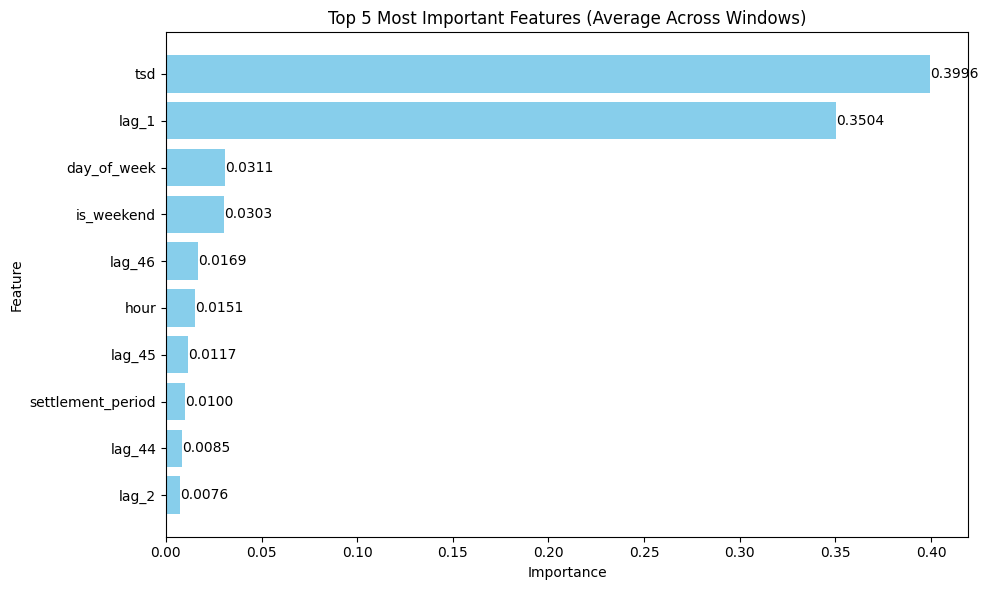

In [55]:
# Calculate the average feature importance across all windows
average_importances = np.mean(list(feature_importances.values()), axis=0)

# Create a DataFrame with feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': average_importances
}).sort_values('Importance', ascending=False)

top_features_df = importance_df.head(10)

# Plot average feature importance for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.title("Top 5 Most Important Features (Average Across Windows)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top

# Add labels to the bars
for index, value in enumerate(top_features_df['Importance']):
    plt.text(value, index, f"{value:.4f}", va='center')

plt.tight_layout()
plt.show()



### Recursive Forecasting

In [69]:

def run_recursive(xgb_params, splits):
    print("\nPerforming recursive forecasting...")

    # Start timing recursive forecasting
    recursive_start_time = time.time()
    results_log = {}
    for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
        xgb_model = xgb.XGBRegressor(**xgb_params)
        
        # Train the model
        xgb_model.fit(
            X_train,
            y_train,
            verbose=False
        )
        
        # Make recursive forecasts
        recursive_preds = recursive_forecast(xgb_model, X_test, steps=FORECAST_HORIZON)

        # Calculate metrics
        mse = mean_squared_error(y_test, recursive_preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, recursive_preds)
        mape = mean_absolute_percentage_error(y_test, recursive_preds)

        results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
    recursive_time = time.time() - recursive_start_time
    print(f"Recursive forecasting completed in {recursive_time:.2f} seconds")
    return results_log
    

In [ ]:
recursive_results = run_recursive(xgb_params, splits)


Performing recursive forecasting...

Making recursive forecasts...

Making recursive forecasts...


In [ ]:
# Calculate average results across all windows
rec_avg_mse = np.mean([result['mes'] for result in recursive_results.values()])
rec_avg_rmse = np.mean([result['rmse'] for result in recursive_results.values()])
rec_avg_mae = np.mean([result['mae'] for result in recursive_results.values()])
rec_avg_mape = np.mean([result['mape'] for result in recursive_results.values()])
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {rec_avg_mse:.2f}")
print(f"Average RMSE: {rec_avg_rmse:.2f}")
print(f"Average MAE: {rec_avg_mae:.2f}")
print(f"Average MAPE: {rec_avg_mape:.2f}%")


Average Results Across All Windows:
Average MSE: 75230163.23
Average RMSE: 7147.21
Average MAE: 6307.10
Average MAPE: 19.42%


In [ ]:
# ## too slow, need to check
# print("\nPerforming recursive forecasting...")

# # Start timing recursive forecasting
# recursive_start_time = time.time()

# for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
#     xgb_model = xgb.XGBRegressor(**xgb_params)
    
#     # Train the model
#     xgb_model.fit(
#         X_train,
#         y_train,
#         verbose=False
#     )
    
#     # Make recursive forecasts
#     recursive_preds = recursive_forecast_with_updates(xgb_model, X_train, X_test, y_train, steps=FORECAST_HORIZON)

#     # Record the time taken for recursive forecasting
#     recursive_time = time.time() - recursive_start_time
#     print(f"Recursive forecasting completed in {recursive_time:.2f} seconds")

#     # Calculate metrics based on the correct predictions
#     mse = mean_squared_error(y_test, recursive_preds)  # Use recursive_preds
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_test, recursive_preds)  # Use recursive_preds
#     mape = mean_absolute_percentage_error(y_test, recursive_preds)  # Use recursive_preds

#     # Log the results
#     results_log[i] = {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}



Performing recursive forecasting...

Making recursive forecasts with model updates...
Recursive forecasting with model updates complete.
Recursive forecasting completed in 316.15 seconds

Making recursive forecasts with model updates...


KeyboardInterrupt: 

In [ ]:
# # Calculate average results across all windows
# rec_avg_mse = np.mean([result['mes'] for result in results_log.values()])
# rec_avg_rmse = np.mean([result['rmse'] for result in results_log.values()])
# rec_avg_mae = np.mean([result['mae'] for result in results_log.values()])
# rec_avg_mape = np.mean([result['mape'] for result in results_log.values()])
# print("\nAverage Results Across All Windows:")
# print(f"Average MSE: {rec_avg_mse:.2f}")
# print(f"Average RMSE: {rec_avg_rmse:.2f}")
# print(f"Average MAE: {rec_avg_mae:.2f}")
# print(f"Average MAPE: {rec_avg_mape:.2f}%")


In [61]:
temp_df = df.resample("30t").sum()

C:\Users\ronsh\AppData\Local\Temp\ipykernel_213732\3453917376.py:1: FutureWarning: 't' is deprecated and will be removed in a future version, please use 'min' instead.
  temp_df = df.resample("30t").sum()


In [63]:
X_forecaster = temp_df.drop(columns=['tsd'])
y_forecaster = temp_df['tsd']

In [ ]:
# X_train_forecaster, X_test_forecaster, y_train_forecaster, y_test_forecaster = train_test_split_ts(X_forecaster, y_forecaster, TEST_SIZE)

In [64]:
sk_splits = walk_forward_validation(X_forecaster, y_forecaster, n_windows=10)

Created 10 validation windows with forecast horizon of 48


In [ ]:
def run_forecaster(xgb_params, sk_splits):
    print("\nTraining SKForecast ForecasterRecursive model...")
    results_log = {}
    sk_start_time = time.time()
    for i, (X_train_forecaster, X_test_forecaster, y_train_forecaster, y_test_forecaster) in enumerate(sk_splits):

        print(f"\nTraining on window number {i + 1}...")

        regressor = xgb.XGBRegressor(**xgb_params)
        lags_grid = list(range(1, LAG_PERIODS + 1))

        # Initialize the forecaster
        forecaster = ForecasterRecursive(
            regressor=regressor,
            lags=lags_grid
        )
        forecaster.fit(y=y_train_forecaster, exog=X_train_forecaster)

        print(f"\nTesting on window number {i + 1}...")

        preds = forecaster.predict(
        steps=FORECAST_HORIZON,
        exog=X_test_forecaster
    )
            # Calculate metrics
        mse = mean_squared_error(y_test_forecaster, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_forecaster, preds)
        mape = mean_absolute_percentage_error(y_test_forecaster, preds)

        results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
    sk_time = time.time() - sk_start_time
    print(f"SKForecast Recursive forecasting completed in {sk_time:.2f} seconds")

    return results_log

In [67]:
forecaster_results = run_forecaster(xgb_params, sk_splits)


Training SKForecast ForecasterRecursive model...

Training on window number 1...

Testing on window number 1...

Training on window number 2...

Testing on window number 2...

Training on window number 3...

Testing on window number 3...

Training on window number 4...

Testing on window number 4...

Training on window number 5...

Testing on window number 5...

Training on window number 6...

Testing on window number 6...

Training on window number 7...

Testing on window number 7...

Training on window number 8...

Testing on window number 8...

Training on window number 9...

Testing on window number 9...

Training on window number 10...

Testing on window number 10...
SKForecast Recursive forecasting completed in 103.13 seconds


In [68]:
# Calculate average results across all windows
sk_avg_mse = np.mean([result['mes'] for result in forecaster_results.values()])
sk_avg_rmse = np.mean([result['rmse'] for result in forecaster_results.values()])
sk_avg_mae = np.mean([result['mae'] for result in forecaster_results.values()])
sk_avg_mape = np.mean([result['mape'] for result in forecaster_results.values()])  
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {sk_avg_mse:.2f}")
print(f"Average RMSE: {sk_avg_rmse:.2f}")
print(f"Average MAE: {sk_avg_mae:.2f}")
print(f"Average MAPE: {sk_avg_mape:.2f}%")



Average Results Across All Windows:
Average MSE: 3614676.28
Average RMSE: 1503.63
Average MAE: 1174.14
Average MAPE: 3.72%


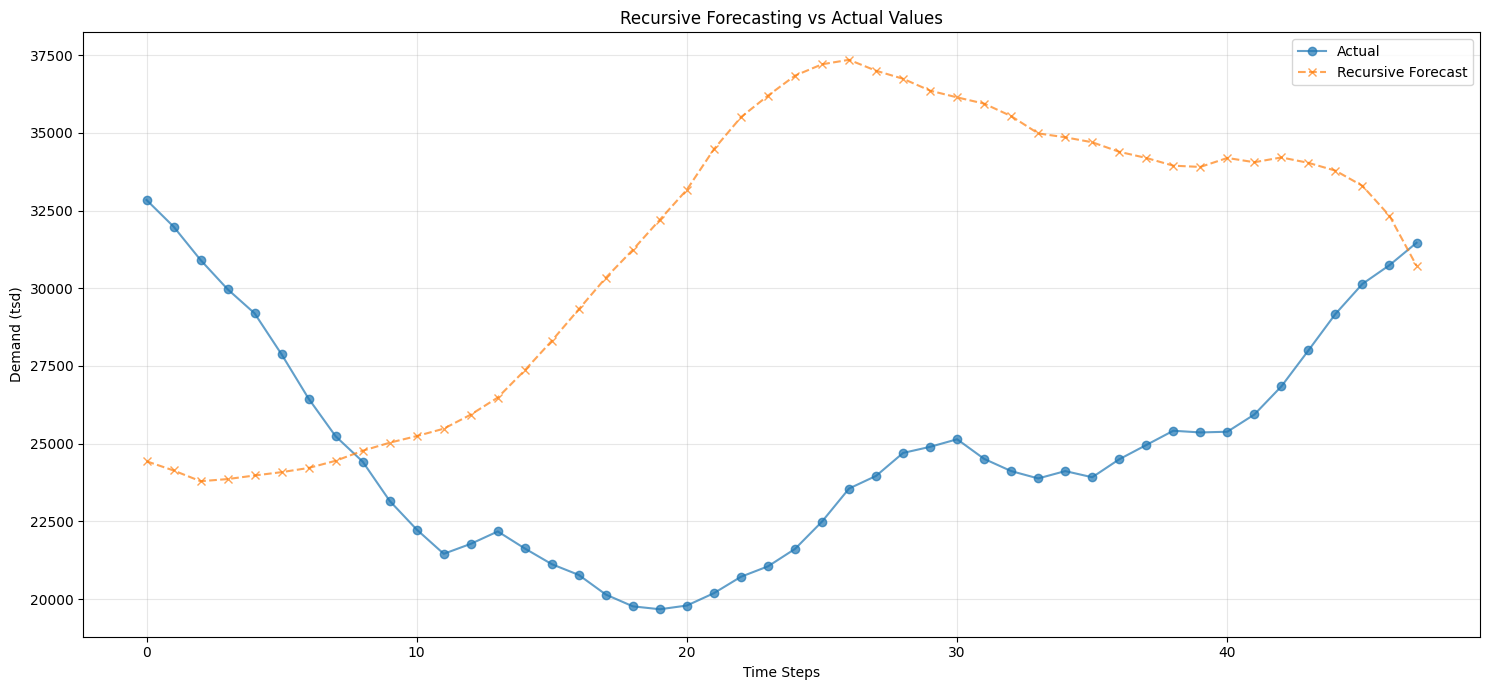

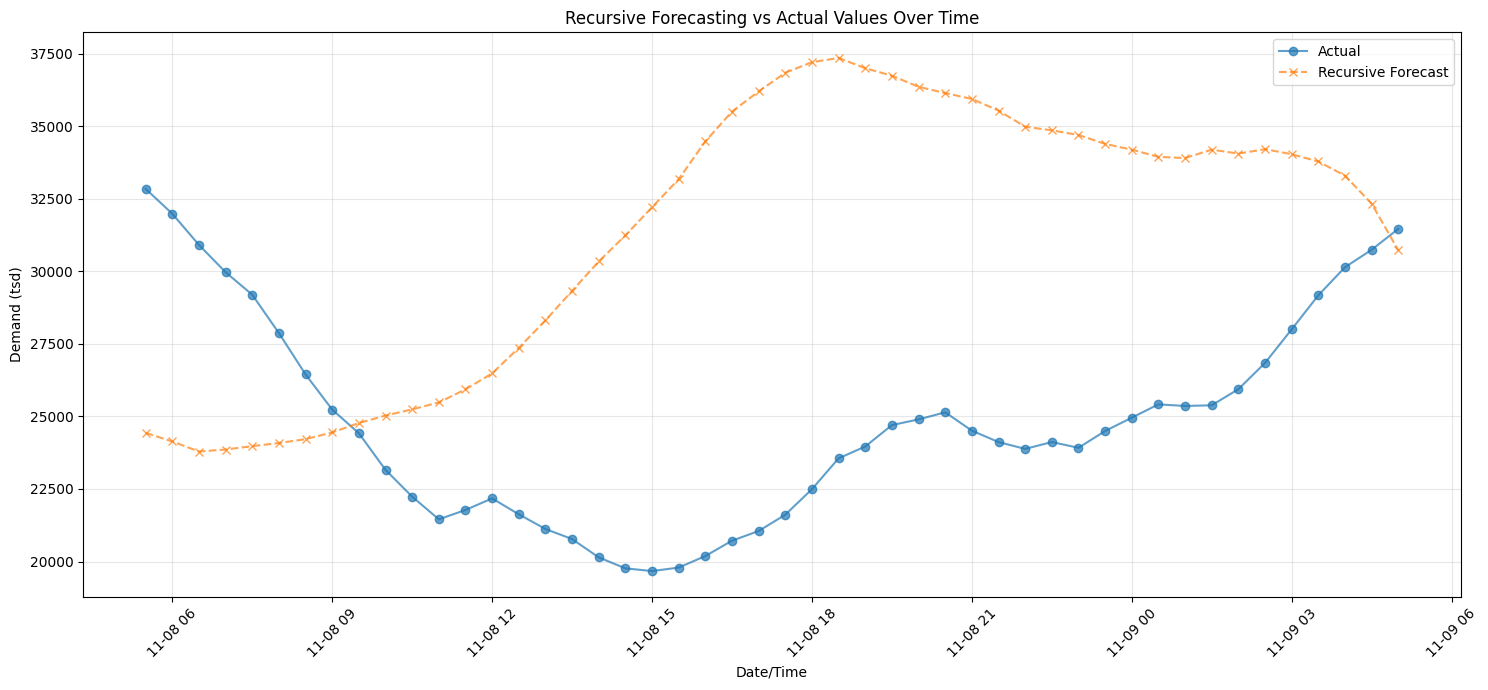

In [ ]:
# Plot recursive forecasting results
plt.figure(figsize=(15, 7))
plt.plot(actual_values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(recursive_preds, label='Recursive Forecast', marker='x', linestyle='--', alpha=0.7)
plt.title('Recursive Forecasting vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Demand (tsd)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize predictions vs actual over time
plt.figure(figsize=(15, 7))
time_idx = y_test.index[start_idx:start_idx+forecast_length]
plt.plot(time_idx, actual_values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(time_idx, recursive_preds, label='Recursive Forecast', marker='x', linestyle='--', alpha=0.7)
plt.title('Recursive Forecasting vs Actual Values Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Demand (tsd)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


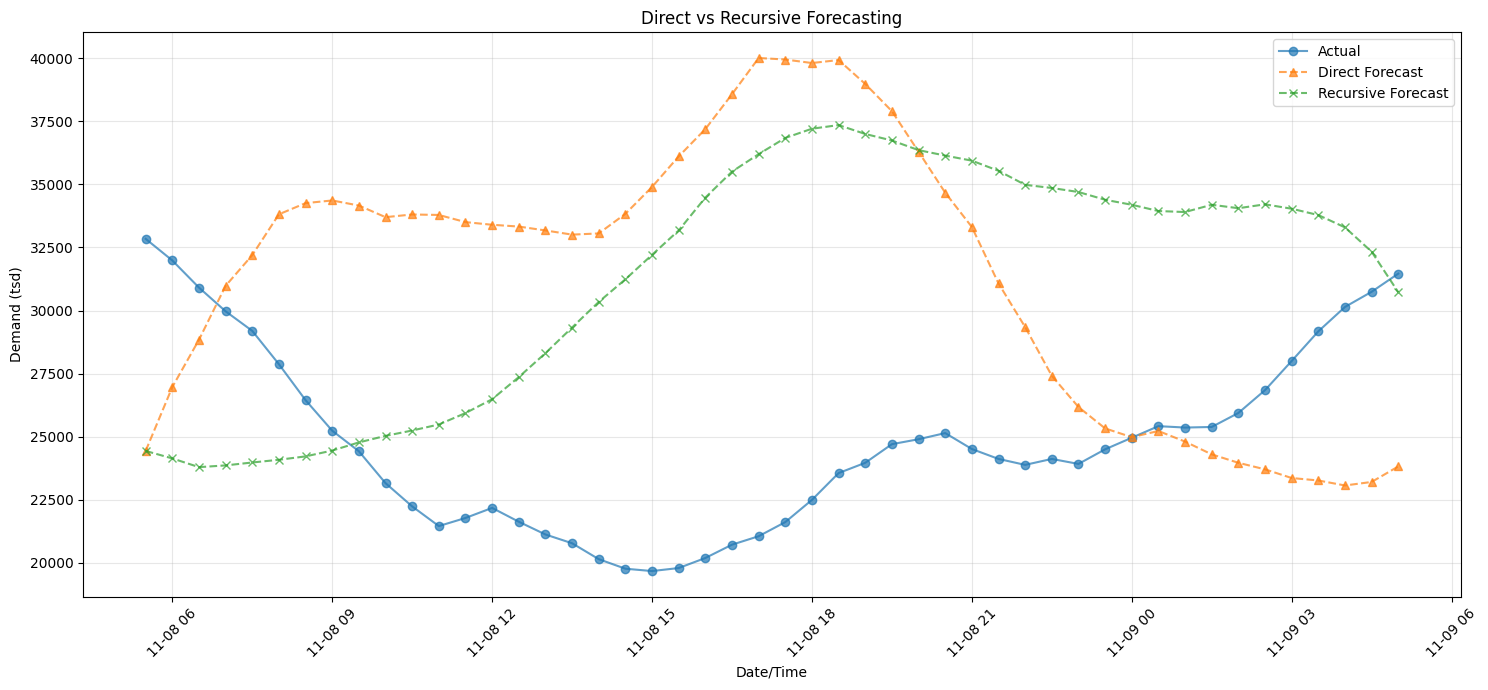


Comparison of Direct vs Recursive Forecasts (First 10 rows):
    Actual        Direct     Recursive
0  32843.0  24433.808594  24433.808594
1  31986.0  26965.806641  24137.064453
2  30911.0  28840.650391  23791.207031
3  29970.0  30979.783203  23860.214844
4  29194.0  32198.269531  23975.662109
5  27872.0  33816.152344  24083.429688
6  26447.0  34259.476562  24217.730469
7  25236.0  34364.921875  24449.093750
8  24421.0  34163.613281  24772.300781
9  23157.0  33702.625000  25031.294922


In [ ]:
# Compare direct vs recursive forecasting
plt.figure(figsize=(15, 7))
direct_preds = y_pred[start_idx:start_idx+forecast_length]
plt.plot(time_idx, actual_values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(time_idx, direct_preds, label='Direct Forecast', marker='^', linestyle='--', alpha=0.7)
plt.plot(time_idx, recursive_preds, label='Recursive Forecast', marker='x', linestyle='--', alpha=0.7)
plt.title('Direct vs Recursive Forecasting')
plt.xlabel('Date/Time')
plt.ylabel('Demand (tsd)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a DataFrame to compare direct and recursive forecasts
comparison_df = pd.DataFrame({
    'Actual': actual_values,
    'Direct': direct_preds,
    'Recursive': recursive_preds
})
print("\nComparison of Direct vs Recursive Forecasts (First 10 rows):")
print(comparison_df.head(10))

In [ ]:
# Cell 16: Multi-horizon Forecast Evaluation
# ## Evaluating Performance Across Different Horizons

def evaluate_multi_horizon(model, X_test, y_test, max_horizon=48):
    """
    Evaluate model performance across multiple forecast horizons.

    Args:
        model (XGBRegressor): Trained model
        X_test (DataFrame): Test features
        y_test (Series): Test targets
        max_horizon (int): Maximum forecast horizon to evaluate

    Returns:
        DataFrame: Performance metrics for each horizon
    """
    results = []

    print(f"\nEvaluating performance across forecast horizons (1 to {max_horizon})...")

    for horizon in range(1, max_horizon+1):
        if horizon % 10 == 0 or horizon == 1 or horizon == max_horizon:
            print(f"Evaluating horizon {horizon}/{max_horizon}...")

        # Make recursive forecasts for this horizon
        forecasts = []
        actuals = []

        # We need enough data in the test set to make a forecast for this horizon
        for i in range(len(X_test) - horizon):
            initial_data = X_test.iloc[i:i+1]
            forecast = recursive_forecast(model, initial_data, steps=horizon)
            forecasts.append(forecast[-1])  # We only care about the forecast at the target horizon
            actuals.append(y_test.iloc[i+horizon-1])

        # Calculate metrics
        if len(forecasts) > 0:
            mae = mean_absolute_error(actuals, forecasts)
            mse = mean_squared_error(actuals, forecasts)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(actuals, forecasts)

            results.append({
                'Horizon': horizon,
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'Samples': len(forecasts)
            })

    return pd.DataFrame(results)

In [ ]:

# Evaluate performance across multiple horizons (limited to a few samples for speed)
print("\nEvaluating performance across forecast horizons...")
max_samples = min(48, len(X_test) - 48)  # Use at most 48 samples
horizon_results = evaluate_multi_horizon(xgb_model, X_test[:max_samples], y_test[:max_samples], max_horizon=48)

# Save the horizon results to a CSV file
horizon_results.to_csv('forecast_horizon_metrics.csv', index=False)
print("Saved horizon metrics to forecast_horizon_metrics.csv")

# Display summary of horizon results
print("\nSummary of forecast performance by horizon:")
print(f"Average MAPE across all horizons: {horizon_results['MAPE'].mean():.2f}%")
print(f"Best MAPE: {horizon_results['MAPE'].min():.2f}% at horizon {horizon_results.loc[horizon_results['MAPE'].idxmin(), 'Horizon']}")
print(f"Worst MAPE: {horizon_results['MAPE'].max():.2f}% at horizon {horizon_results.loc[horizon_results['MAPE'].idxmax(), 'Horizon']}")

# Cell 17: Visualizing Performance by Horizon
# ## Plotting Error Metrics Across Forecast Horizons

# Plot results by horizon
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(horizon_results['Horizon'], horizon_results['RMSE'], marker='o')
plt.title('RMSE by Forecast Horizon')
plt.xlabel('Forecast Horizon (periods)')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(horizon_results['Horizon'], horizon_results['MAPE'], marker='o')
plt.title('MAPE by Forecast Horizon')
plt.xlabel('Forecast Horizon (periods)')
plt.ylabel('MAPE (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot a more detailed view of horizon performance
plt.figure(figsize=(12, 6))
plt.plot(horizon_results['Horizon'], horizon_results['MAE'], marker='o', label='MAE')
plt.plot(horizon_results['Horizon'], horizon_results['RMSE'], marker='s', label='RMSE')
plt.title('Error Metrics by Forecast Horizon')
plt.xlabel('Forecast Horizon (periods)')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Evaluating performance across forecast horizons...

Evaluating performance across forecast horizons (1 to 48)...
Evaluating horizon 1/48...
Evaluating horizon 10/48...
Evaluating horizon 20/48...
Evaluating horizon 30/48...
Evaluating horizon 40/48...
Evaluating horizon 48/48...
Saved horizon metrics to forecast_horizon_metrics.csv

Summary of forecast performance by horizon:


KeyError: 'MAPE'

In [ ]:
# Save model for later use
model_filename = 'xgboost_recursive_forecast_model.json'
xgb_model.save_model(model_filename)
print(f"Model saved to {model_filename}")

# Save predictions for further analysis
results_df = pd.DataFrame({
    'timestamp': time_idx,
    'actual': actual_values,
    'direct_forecast': direct_preds,
    'recursive_forecast': recursive_preds,
    'skforecast': skf_preds.values,
    'simple_forecast': simple_preds.values
})
results_df.to_csv('forecast_results.csv')
print("Saved forecast results to forecast_results.csv")

# Performance Comparison and Conclusions

# Create a summary DataFrame for easy comparison
summary_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'Train Time (s)', 'Prediction Time (s)'],
    'Direct XGBoost': [mae, rmse, mape, training_time, prediction_time],
    'Custom Recursive': [rec_mae, rec_rmse, rec_mape, training_time, recursive_time],
    'SKForecast (48 lags)': [skf_mae, skf_rmse, skf_mape, skf_train_time, skf_pred_time],
    'SKForecast (5 lags)': [simple_mae, simple_rmse, simple_mape, simple_train_time, simple_pred_time]
})

# Final summary of performance metrics
print("\n=== FINAL PERFORMANCE SUMMARY ===")
print(f"Direct XGBoost MAPE: {mape:.2f}%")
print(f"Custom Recursive MAPE: {rec_mape:.2f}%")
print(f"SKForecast (48 lags) MAPE: {skf_mape:.2f}%")
print(f"SKForecast (5 lags) MAPE: {simple_mape:.2f}%")
print("==================================\n")

# Print detailed comparison table
print("Full Performance Comparison:")
print(summary_df)

# Create a comparison plot
plt.figure(figsize=(15, 7))
plt.plot(time_idx, actual_values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(time_idx, direct_preds, label=f'Direct XGBoost (MAPE: {mape:.2f}%)', marker='^', linestyle='--', alpha=0.7)
plt.plot(time_idx, recursive_preds, label=f'Custom Recursive (MAPE: {rec_mape:.2f}%)', marker='x', linestyle='--', alpha=0.7)
plt.plot(time_idx, skf_preds.values, label=f'SKForecast 48 lags (MAPE: {skf_mape:.2f}%)', marker='s', linestyle='--', alpha=0.7)
plt.plot(time_idx, simple_preds.values, label=f'SKForecast 5 lags (MAPE: {simple_mape:.2f}%)', marker='d', linestyle='--', alpha=0.7)
plt.title('Comparison of Forecasting Methods')
plt.xlabel('Date/Time')
plt.ylabel('Demand (tsd)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('forecast_methods_comparison.png')
plt.show()

print("\nXGBoost Recursive Forecasting Model Complete.")
print("This notebook demonstrates multiple forecasting approaches for time series data:")
print("1. Direct forecasting with XGBoost")
print("2. Custom recursive forecasting with XGBoost")
print("3. SKForecast with different lag configurations")
print("\nThe results highlight the trade-offs between these approaches and provide insights for model selection.")



Model saved to xgboost_recursive_forecast_model.json
Saved forecast results to forecast_results.csv

=== FINAL PERFORMANCE SUMMARY ===
Direct Prediction Average MAPE: 4.77%
Recursive Prediction Average MAPE: 14.19%
Difference: 9.43%
Percentage Improvement: 197.78%

Full Performance Comparison:
     Metric  Direct Forecasting  Recursive Forecasting   Difference
0       MAE         1328.893622            3303.808797  1974.915176
1      RMSE         1758.509350            4013.934408  2255.425058
2  MAPE (%)            4.766039              14.192262     9.426222

XGBoost Recursive Forecasting Model Complete.
This notebook demonstrates both direct and recursive forecasting approaches for time series data.
The results highlight the trade-offs between these approaches and provide insights for model selection.
